# Práctica Final de Despliegue de Algoritmos

## 1. Exploración de datos

In [1]:
import pandas as pd

df = pd.read_json(r'C:\Users\Jonay\Desktop\ENTREGA\Despliegue Algoritmos\Movies_and_TV_5.json', lines = True)

Debido al tamaño del dataset, seleccionamos aleatoriamente 10.000 muestras, de las cuales la mitad sean positivas y la otra mitad negativas para evitar sesgos.

In [3]:
positive_reviews = df[df['overall'] > 3]
negative_reviews = df[df['overall'] <= 3]

# 5000 muestras aleatorias de cada grupo
positive_sample = positive_reviews.sample(n=5000, random_state=42)
negative_sample = negative_reviews.sample(n=5000, random_state=42)

# Combinar las muestras y barajarlas
df_balanced = pd.concat([positive_sample, negative_sample]).sample(frac=1, random_state=42)

* Antes de proceder con la exploración, dividimos el dataset en train y test.

In [6]:
import numpy as np
print(np.__version__)

1.23.5


In [7]:
from sklearn.model_selection import train_test_split

train_data, temp_data = train_test_split(df_balanced, test_size=0.3, stratify=df_balanced['overall'], random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['overall'], random_state=42)

print(f"Train: {len(train_data)}, Validation: {len(val_data)}, Test: {len(test_data)}")

Train: 7000, Validation: 1500, Test: 1500


In [8]:
df_reviews = train_data.drop(['reviewerID', 'asin', 'reviewerName', 'helpful', 'summary','unixReviewTime', 'reviewTime'], axis=1)

In [9]:
df_reviews.head()

,reviewText,overall
981026,i saw the first 10 min and i felt sleephow can...,1
627486,Meet the Fockers is much better than the first...,3
962869,"First off, the title was not right, but I gues...",3
1573632,Loved the clothes and the settings.I liked all...,4
387615,There's not much left to say in praise of this...,5


In [10]:
df_reviews.value_counts(df_reviews['overall']>3)

overall
False    3500
True     3500
Name: count, dtype: int64

* Tokenizamos nuestros datos para poder explorarlos correctamente

In [13]:
import spacy
import en_core_web_sm

nlp = en_core_web_sm.load()

df_reviews['tokens'] = df_reviews['reviewText'].apply(
    lambda x: [token.text for token in nlp(x)])

In [14]:
df_reviews['tokens'].head()

981026     [i, saw, the, first, 10, min, and, i, felt, sl...
627486     [Meet, the, Fockers, is, much, better, than, t...
962869     [First, off, ,, the, title, was, not, right, ,...
1573632    [Loved, the, clothes, and, the, settings, ., I...
387615     [There, 's, not, much, left, to, say, in, prai...
Name: tokens, dtype: object

In [15]:
words_list = [" ".join(tokens) for tokens in df_reviews['tokens']]
print(words_list[0])

i saw the first 10 min and i felt sleephow can anyone act like that ? ? ? nothing i can say1 star is a way too much for it


In [16]:
all_words = " ".join(words_list).split()
print(all_words[:10])

['i', 'saw', 'the', 'first', '10', 'min', 'and', 'i', 'felt', 'sleephow']


In [17]:
len(all_words)

1410076

## 1.1. Cardinalidad del vocabulario

In [18]:
vocab = set(all_words)
len(vocab)

57906

In [19]:
from collections import Counter
import matplotlib.pyplot as plt

wf = Counter(all_words)
wf.most_common(10)

[('the', 60537),
 ('.', 58999),
 (',', 56462),
 ('and', 33179),
 ('a', 31710),
 ('of', 29845),
 ('to', 27440),
 ('is', 22669),
 ('I', 17798),
 ('in', 17440)]

## 1.2. Distribución de reviews por número de estrellas

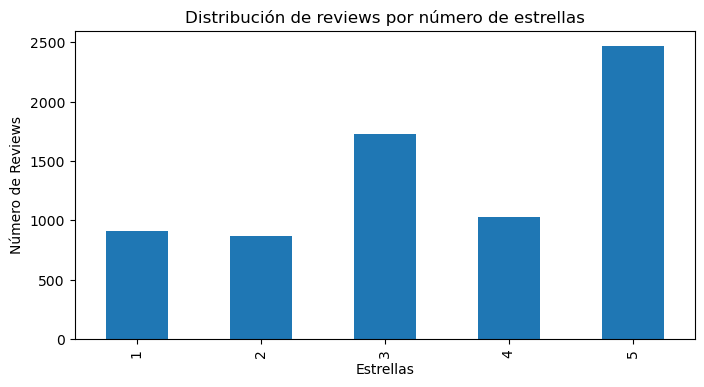

In [20]:
df_plot = df_reviews['overall'].value_counts(sort=False).sort_index()
df_plot = df_plot.plot(kind='bar', title='Distribución de reviews por número de estrellas', xlabel='Estrellas', ylabel='Número de Reviews',figsize=(8, 4))

## 1.3. Nº de reviews positivas y negativas

In [21]:
print(f"Número total de reviews positivas: {len(df_reviews[df_reviews['overall']>3])}'")
print(f"Número total de reviews negativas: {len(df_reviews[df_reviews['overall']<3])}'")

Número total de reviews positivas: 3500'
Número total de reviews negativas: 1771'


## 1.4. N-grams más frecuentes

In [23]:
from nltk import ngrams
from nltk.probability import FreqDist

bigrams_ = list(ngrams(all_words, 2))
trigrams_ = list(ngrams(all_words, 3))

In [24]:
bigrams_freq = FreqDist(bigrams_)
trigrams_freq = FreqDist(trigrams_)

In [25]:
bigrams_freq.most_common(10)

[(('of', 'the'), 8176),
 (('.', 'The'), 6815),
 ((',', 'and'), 6212),
 (('.', 'I'), 6071),
 (('in', 'the'), 4618),
 ((',', 'but'), 4600),
 (('.', 'It'), 3249),
 ((',', 'the'), 3126),
 (('is', 'a'), 3059),
 (('.', 'This'), 2649)]

In [26]:
trigrams_freq.most_common(10)

[(('.', 'It', "'s"), 1070),
 (('.', 'This', 'is'), 903),
 (('one', 'of', 'the'), 746),
 ((',', 'and', 'the'), 711),
 (('.', 'If', 'you'), 658),
 (('.', 'It', 'is'), 621),
 (('of', 'the', 'film'), 531),
 (('I', 'do', "n't"), 517),
 (('!', '!', '!'), 514),
 ((',', 'but', 'I'), 513)]

## 1.5. Nubes de palabras

In [28]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

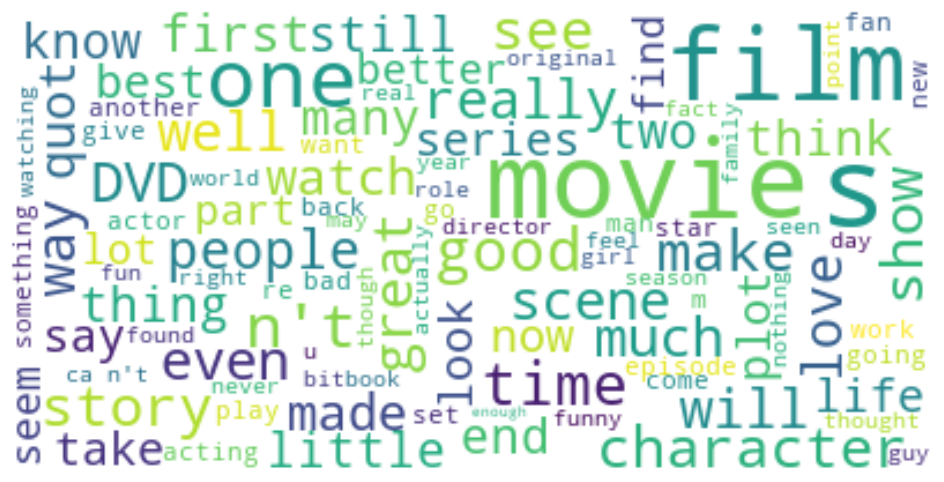

In [29]:
plot_word_cloud(all_words)

# 2. Preprocesamiento de texto

In [30]:
def remove_stopwords(doc):
    return [token for token in doc if not token.is_stop]
def remove_punct(doc):
    return [token for token in doc if not token.is_punct]
def remove_numbers(doc):
    return [token for token in doc if not token.like_num]
def remove_short_tokens(doc, min_length=3):
    return [token for token in doc if len(token) >= min_length]
def lemmatization(doc):
    return [token.lemma_ for token in doc]

In [31]:
def cleaning(text):
  text = text.lower()
  doc = nlp(text)
  tokens = remove_stopwords(doc)
  tokens = remove_punct(tokens)
  tokens = remove_numbers(tokens)
  tokens = remove_short_tokens(tokens)
  tokens = lemmatization(tokens)
  return ' '.join(tokens)

In [32]:
df_reviews['cleaned_text'] = df_reviews['reviewText'].apply(cleaning)

In [33]:
df_reviews.head()

,reviewText,overall,tokens,cleaned_text
981026,i saw the first 10 min and i felt sleephow can...,1,"[i, saw, the, first, 10, min, and, i, felt, sl...",see min feel sleephow act like say1 star way
627486,Meet the Fockers is much better than the first...,3,"[Meet, the, Fockers, is, much, better, than, t...",meet focker well movie meet parent moment soon...
962869,"First off, the title was not right, but I gues...",3,"[First, off, ,, the, title, was, not, right, ,...",title right guess butterfly effect take time w...
1573632,Loved the clothes and the settings.I liked all...,4,"[Loved, the, clothes, and, the, settings, ., I...",love clothe settings.i like character selfridg...
387615,There's not much left to say in praise of this...,5,"[There, 's, not, much, left, to, say, in, prai...",left praise film gabriel byrne kevin spacey su...


* Dividimos el dataset y aplicamos las transformaciones necesarias sobre los datos de validación y test.

In [34]:
x_train = df_reviews['cleaned_text']
y_train = df_reviews['overall'].apply(lambda x: 1 if x > 3 else 0)

In [35]:
val_data['cleaned_text'] = val_data['reviewText'].apply(cleaning)
test_data['cleaned_text'] = test_data['reviewText'].apply(cleaning)
x_val = val_data['cleaned_text']
y_val = val_data['overall'].apply(lambda x: 1 if x > 3 else 0)
x_test = test_data['cleaned_text']
y_test = test_data['overall'].apply(lambda x: 1 if x > 3 else 0)

# 3. Entrenamiento del modelo

* Extracción de características con TF-IDF

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

cv = TfidfVectorizer(
    max_df=0.9,
    min_df=4,
    max_features=2000,
    strip_accents='ascii',
    ngram_range=(1, 1)
)
cv.fit(x_train)

TfidfVectorizer(max_df=0.9, max_features=2000, min_df=4, strip_accents='ascii')

In [37]:
print(list(cv.vocabulary_.items())[:20])

[('see', 1569), ('min', 1142), ('feel', 671), ('act', 23), ('like', 1042), ('star', 1687), ('way', 1933), ('meet', 1119), ('well', 1946), ('movie', 1172), ('parent', 1277), ('moment', 1156), ('soon', 1659), ('annoying', 83), ('character', 279), ('installment', 923), ('robert', 1510), ('owen', 1260), ('ben', 173), ('this', 1807)]


In [38]:
print(len(cv.vocabulary_))

2000


In [39]:
x_train_cv = cv.transform(x_train)
x_val_cv = cv.transform(x_val)
x_test_cv = cv.transform(x_test)

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model = LogisticRegression(
    max_iter=1000, 
    solver='lbfgs', 
    penalty='l2', 
    C=1.0, 
    class_weight=None
)
model.fit(x_train_cv, y_train)

LogisticRegression(max_iter=1000)

In [44]:
y_val_pred = model.predict(x_val_cv)
print("Modelo 2 - Accuracy en validación:", accuracy_score(y_val, y_val_pred))
print("\nModelo 2 - Reporte de clasificación:\n", classification_report(y_val, y_val_pred))

Modelo 2 - Accuracy en validación: 0.7886666666666666

Modelo 2 - Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      0.79      0.79       751
           1       0.79      0.78      0.79       749

    accuracy                           0.79      1500
   macro avg       0.79      0.79      0.79      1500
weighted avg       0.79      0.79      0.79      1500



# 4. Evaluación del modelo

In [45]:
y_test_pred = model.predict(x_test_cv)
print("Modelo 1 - Accuracy en test:", accuracy_score(y_test, y_test_pred))
print("\nModelo 1 - Reporte de clasificación:\n", classification_report(y_test, y_test_pred))

Modelo 1 - Accuracy en validación: 0.7486666666666667

Modelo 1 - Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75       749
           1       0.75      0.75      0.75       751

    accuracy                           0.75      1500
   macro avg       0.75      0.75      0.75      1500
weighted avg       0.75      0.75      0.75      1500



# 5. Registro de métricas con MLflow

In [47]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import subprocess

# Lista de n_estimators
n_stimators = [2, 10, 20, 30, 50, 80, 100, 130]

# Iniciar el servidor MLflow
mlflow_ui_process = subprocess.Popen(['mlflow', 'ui', '--port', '5000'])

# Configurar el experimento en MLflow
mlflow.set_experiment('Pruebas del modelo')

# Iterar sobre los valores de n_estimators
for i in n_stimators:
    with mlflow.start_run() as run:
        # Configurar el modelo
        clf = RandomForestClassifier(
            n_estimators=i,
            min_samples_leaf=2,
            class_weight='balanced',
            random_state=123
        )

        # Preprocesador y pipeline
        preprocessor = Pipeline(steps=[('scaler', StandardScaler(with_mean=False))])
        model = Pipeline(steps=[('preprocessor', preprocessor),
                                ('RandomForestClassifier', clf)])
        
        # Entrenar el modelo
        model.fit(x_train_cv, y_train)
        
        # Evaluar en conjunto de entrenamiento y prueba
        accuracy_train = model.score(x_train_cv, y_train)
        accuracy_test = model.score(x_test_cv, y_test)

        # Registrar métricas y parámetros en MLflow
        mlflow.log_metric('accuracy_train', accuracy_train)
        mlflow.log_metric('accuracy_test', accuracy_test)
        mlflow.log_param('n_estimators', i)
        
        # Guardar el modelo en MLflow
        mlflow.sklearn.log_model(model, 'clf-model')

# Nota: Asegúrate de detener el servidor MLflow cuando termines
# mlflow_ui_process.terminate()

2024/12/14 11:59:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/14 11:59:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/14 11:59:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/14 12:00:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/14 12:00:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/14 12:00:45 

![Imagen 1](MLflow1.png)

![Imagen 2](MLflow2.png)

![Imagen 3](MLflow3.png)

# 5. Generar .py de funciones y main con al menos dos argumentos de entrada

## 5.1. Funciones

In [ ]:
import argparse
import subprocess
import time
import mlflow
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import spacy
import en_core_web_sm

def argumentos():
    parser = argparse.ArgumentParser(description="Modelo con MLflow")
    parser.add_argument('--nombre_job', type=str, help='Nombre del trabajo en MLflow')
    parser.add_argument('--n_estimators_list', nargs='+', type=int, help='Lista de n_estimators')
    return parser.parse_args()

def load_dataset():
    # Cargamos el dataset desde el archivo JSON
    df = pd.read_json(r'C:\Users\Jonay\Desktop\ENTREGA\Despliegue Algoritmos\Movies_and_TV_5.json', lines=True)
    return df

def data_treatment(df):
    # Filtramos reseñas positivas y negativas
    positive_reviews = df[df['overall'] > 3]
    negative_reviews = df[df['overall'] <= 3]

    # Tomamos 5000 muestras aleatorias de cada grupo
    positive_sample = positive_reviews.sample(n=5000, random_state=42)
    negative_sample = negative_reviews.sample(n=5000, random_state=42)
    df_balanced = pd.concat([positive_sample, negative_sample]).sample(frac=1, random_state=42)

    # Separamos en train, val y test
    train_data, temp_data = train_test_split(df_balanced, test_size=0.3, stratify=df_balanced['overall'], random_state=42)
    val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['overall'], random_state=42)

    print(f"Train: {len(train_data)}, Validation: {len(val_data)}, Test: {len(test_data)}")

    return train_data, val_data, test_data

def extract_features(train_data, val_data, test_data):
    cv = TfidfVectorizer(
        max_df=0.9,
        min_df=4,
        max_features=2000,
        strip_accents='ascii',
        ngram_range=(1, 1)
    )
    
    x_train_cv = cv.fit_transform(train_data['reviewText'])
    x_val_cv = cv.transform(val_data['reviewText'])
    x_test_cv = cv.transform(test_data['reviewText'])
    
    return x_train_cv, x_val_cv, x_test_cv

def mlflow_tracking(nombre_job, x_train_cv, x_val_cv, x_test_cv, y_train, y_test, n_estimators):
    mlflow_ui_process = subprocess.Popen(['mlflow', 'ui', '--port', '5000'])
    print(mlflow_ui_process)
    time.sleep(5)
    mlflow.set_experiment(nombre_job)

    for i in n_estimators:
        with mlflow.start_run() as run:
            # Crear y entrenar el modelo de regresión logística
            model = LogisticRegression(
                max_iter=1000, 
                solver='lbfgs', 
                penalty='l2', 
                C=1.0, 
                class_weight=None
            )
            model.fit(x_train_cv, y_train)
            y_test_pred = model.predict(x_test_cv)
            
            accuracy_test = accuracy_score(y_test, y_test_pred)
            mlflow.log_metric('accuracy_test', accuracy_test)
            mlflow.log_param('n_estimators', i)
            mlflow.log_param('model_type', 'LogisticRegression')
            mlflow.sklearn.log_model(model, 'clf-model')
            print(f"Modelo con {i} estimadores - Accuracy en test: {accuracy_test}")
            print("\nReporte de clasificación:\n", classification_report(y_test, y_test_pred))
    print("Se ha acabado el entrenamiento del modelo correctamente")


## 5.2. Main

In [ ]:
from funciones import argumentos, load_dataset, data_treatment, extract_features, mlflow_tracking

def main():
    print("Ejecutamos el main")
    args_values = argumentos() 
    df = load_dataset()
    train_data, val_data, test_data = data_treatment(df)
    x_train_cv, x_val_cv, x_test_cv = extract_features(train_data, val_data, test_data)
    mlflow_tracking(args_values.nombre_job, x_train_cv, x_val_cv, x_test_cv, train_data['overall'], test_data['overall'], args_values.n_estimators_list)  # Ejecutar el tracking con MLflow

if __name__ == "__main__":
    main()

# 6. FastAPI

## 6.1. Captura de pantalla docs con al menos 5 módulos.

![Imagen FastAPI1](FastAPI1.png)

## 6.2. Captura de cada uno de los módulos con la respuesta dentro de docs.

![Imagen FastAPI2](FastAPI2.png)

![Imagen FastAPI3](FastAPI3.png)

![Imagen FastAPI4](FastAPI4.png)

![Imagen FastAPI5](FastAPI5.png)

![Imagen FastAPI6](FastAPI6.png)

## 6.3. Captura de cada uno de los módulos en la llamada https.

![Imagen https1](API1.png)

![Imagen https2](API2.png)

![Imagen https3](API3.png)

![Imagen https4](API4.png)

![Imagen https5](API5.png)

## 6.4. Todo el código usado durante el proceso.

### 6.4.1. FastAPI

In [ ]:
from fastapi import FastAPI
from transformers import pipeline

app = FastAPI()

@app.get('/')
def welcome():
    return {"message": "Bienvenido a la API de Jonay Temino"}

@app.get('/saluda')
def root(name: str): 
    return {'Message': f'Hola {name}, bienvenido!'}

@app.get('/edad')
def age(birth: int): 
    return {'Message': f'Tu edad es de {2024-birth} años.'}

@app.get('/qa')
def question_answering(question: str, context: str): 
    qa_pipeline = pipeline('question-answering')
    answer = qa_pipeline(question=question, context=context)
    return {'answer': answer['answer'], 'score': answer['score']}

@app.get('/translate')
def translate(query: str): 
    translation_pipeline = pipeline('translation_en_to_fr')
    translation = translation_pipeline(query)
    return {'translation': translation[0]['translation_text']}